In [42]:
import os
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

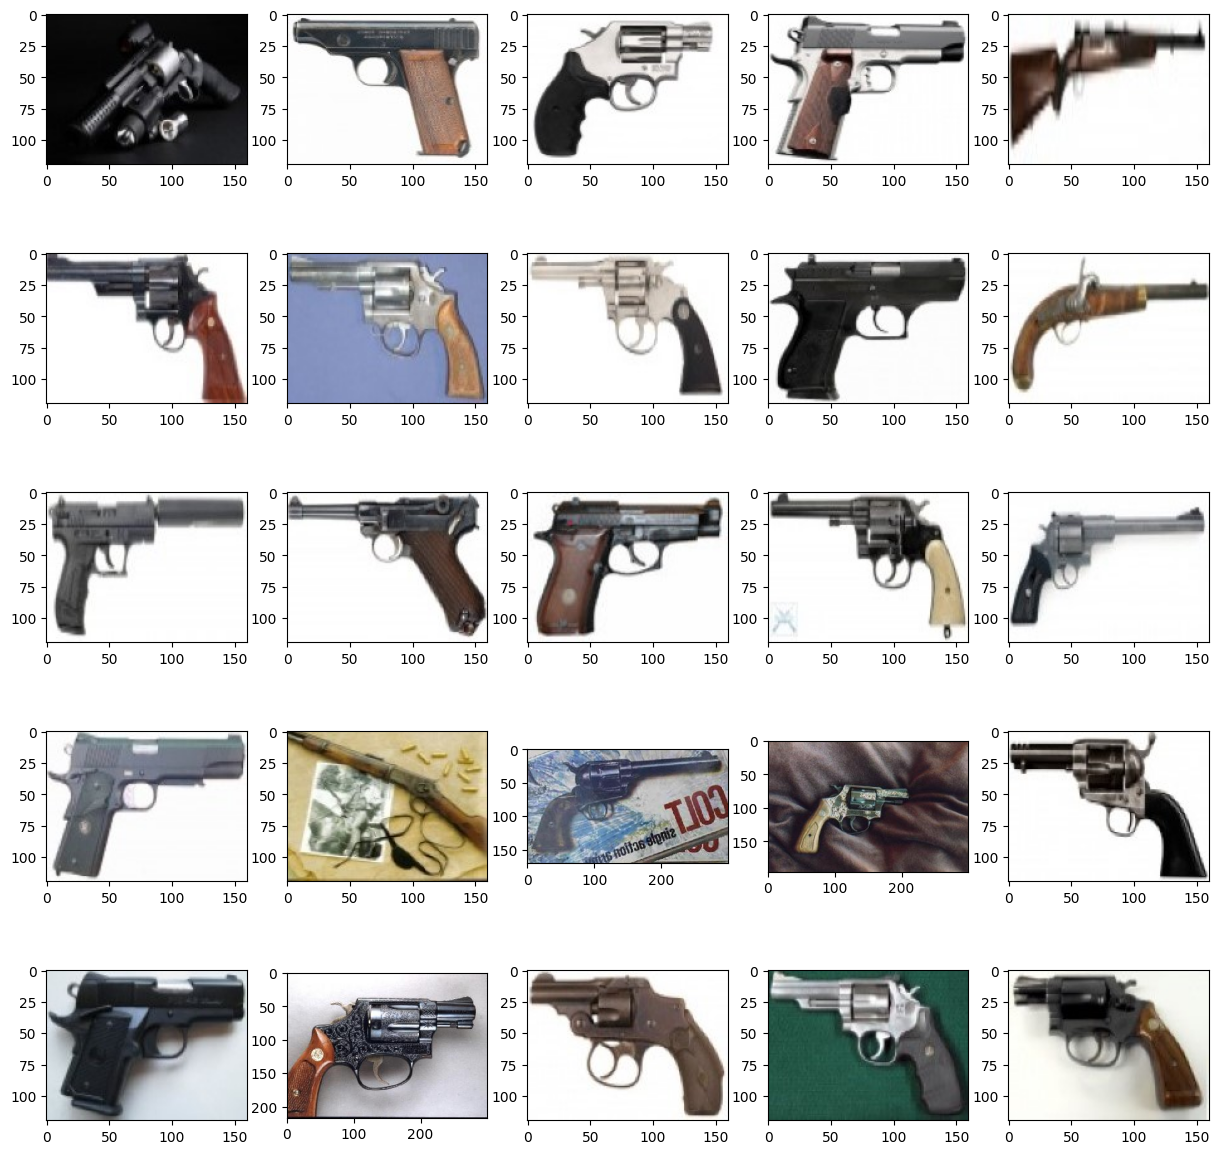

In [43]:
plt.figure(figsize=(15,15))

carpeta = 'raw_data/test_images/train_imgs/pistol/'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
#
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=15,
    zoom_range=[0.5, 1.5],
    validation_split=0.2 
)

In [45]:
data_gen_train = datagen.flow_from_directory(
    'raw_data/test_images/data_balanced',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset='training'
)

Found 1874 images belonging to 3 classes.


In [46]:
data_gen_test = datagen.flow_from_directory(
    'raw_data/test_images/data_balanced',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset='validation'
)

Found 468 images belonging to 3 classes.


In [47]:
PATH ="raw_data/"
FILE="test_video.mp4"
VIDEO = PATH+FILE

In [48]:
cap = cv2.VideoCapture(VIDEO)

# 1.test

In [49]:

def process_video(video_path):
    video = cv2.VideoCapture(video_path)

    while video.isOpened():
        ret, frame = video.read()

        if not ret:
            break

        cv2.imshow('Video', frame)

        if cv2.waitKey(1) == 27:
            break
        cv2.waitKey(25)
    video.release()
    cv2.destroyAllWindows()

process_video(VIDEO)
#abre el video, funciona bien

In [50]:
def preprocess_frame(frame):
    # Preprocess the frame (resize, normalize, etc.)
    resized_frame = cv2.resize(frame, (224, 224))
    normalized_frame = resized_frame / 255.0  # Normalize pixel values between 0 and 1
    preprocessed_frame = tf.expand_dims(normalized_frame, axis=0)  # Add batch dimension
    return preprocessed_frame

In [51]:
def process_video(video_path, model):
    video = cv2.VideoCapture(video_path)
    detections = []

    while video.isOpened():
        ret, frame = video.read()

        if not ret:
            break

        processed_frame = preprocess_frame(frame)

        features = model(processed_frame)

        probabilities = tf.nn.softmax(features)

        class_id = tf.argmax(probabilities, axis=1)
        class_label = class_id.numpy()[0]

        cv2.imshow('Video', frame)

        if class_label == 1:
            detections.append("Pistol or handggun detected!")

        if cv2.waitKey(1) == 27:
            break

        cv2.waitKey(25)

    video.release()
    cv2.destroyAllWindows()

    # Print the detections
    if len(detections) > 0:
        print("Detections:")
        for detection in detections:
            print(detection)
    else:
        print("No pistol or handgun detected.")

# Model

In [52]:
import tensorflow as tf
import tensorflow_hub as hub
#este es el de fabi
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))
mobilenetv2.trainable = False

In [55]:
from tensorflow.keras.layers import Dropout, BatchNormalization, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [56]:
model = tf.keras.Sequential([
    mobilenetv2,
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

#base_model = tf.keras.applications.MobileNetV2(
#                                               include_top=True,
#                                               weights='imagenet')

In [57]:
process_video(VIDEO, model)

No pistol or handgun detected.


In [58]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_12 (Dense)            (None, 1024)              1311744   
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                      

## Acá hay que seguir y ver la precision, comparar con un baseline

In [15]:
#https://github.com/EhabR98/Transfer-Learning-with-MobileNetV2

In [59]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(
    optimizer=adam_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [60]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

In [61]:
#Entrenar el modelo
EPOCHS = 150 
early_stop = EarlyStopping(monitor='val_loss', patience=15)

historial = model.fit(
    data_gen_train, epochs=EPOCHS,
    validation_data=data_gen_test,
    callbacks=[lr_reduction, early_stop]
)


#model.fit(data_gen_train,
#          epochs=EPOCHS,
#          batch_size=32,
#          validation_data=data_gen_test)

Epoch 1/150
59/59 [==============================] - 24s 383ms/step - loss: 2.0756 - accuracy: 0.8949 - val_loss: 1.9412 - val_accuracy: 0.9338 - lr: 5.0000e-04
Epoch 2/150
59/59 [==============================] - 22s 370ms/step - loss: 1.8200 - accuracy: 0.9680 - val_loss: 1.8860 - val_accuracy: 0.9402 - lr: 5.0000e-04
Epoch 3/150
59/59 [==============================] - 22s 367ms/step - loss: 1.7163 - accuracy: 0.9733 - val_loss: 1.8379 - val_accuracy: 0.9359 - lr: 5.0000e-04
Epoch 4/150
59/59 [==============================] - 21s 363ms/step - loss: 1.6178 - accuracy: 0.9787 - val_loss: 1.7811 - val_accuracy: 0.9209 - lr: 5.0000e-04
Epoch 5/150
59/59 [==============================] - 22s 365ms/step - loss: 1.5233 - accuracy: 0.9824 - val_loss: 1.7365 - val_accuracy: 0.9188 - lr: 5.0000e-04
Epoch 6/150
59/59 [==============================] - 22s 368ms/step - loss: 1.4609 - accuracy: 0.9733 - val_loss: 1.5361 - val_accuracy: 0.9573 - lr: 5.0000e-04
Epoch 7/150
59/59 [===============

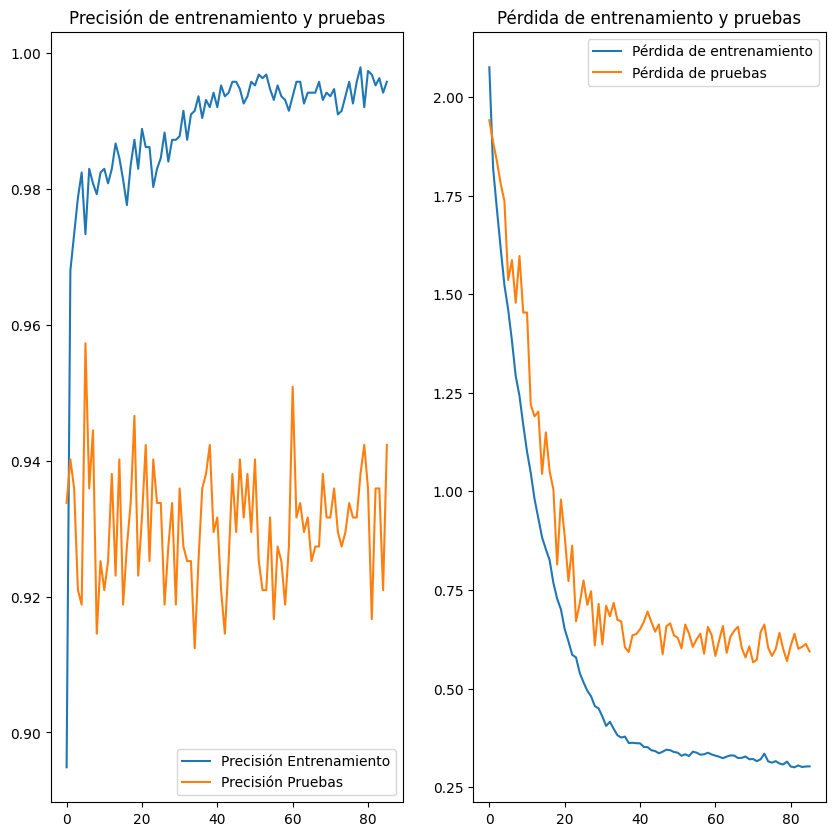

In [62]:
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(86)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [79]:
trackers = {
    'csrt' : cv2.legacy.TrackerCSRT_create,  # hight accuracy ,slow
    'mosse' : cv2.legacy.TrackerMOSSE_create,  # fast, low accuracy
    'kcf' : cv2.legacy.TrackerKCF_create,   # moderate accuracy and speed
    'medianflow' : cv2.legacy.TrackerMedianFlow_create,
    'mil' : cv2.legacy.TrackerMIL_create,
    'tld' : cv2.legacy.TrackerTLD_create,
    'boosting' : cv2.legacy.TrackerBoosting_create,
}

AttributeError: module 'cv2' has no attribute 'legacy'

In [19]:
def process_video(video_path, model):
    video = cv2.VideoCapture(video_path)
    detections = []
    tracker = cv2.TrackerKCF_create()  # Create an object tracker
    initialized = False  # Flag to track if the tracker is initialized
    cv2.TrackerMOSSE_create()
    while True:
        ret, frame = video.read()

        if not ret:
            break

        if not initialized:
            bbox = cv2.selectROI("Select Object", frame, fromCenter=False, showCrosshair=True)
            tracker.init(frame, bbox)  # Initialize the tracker with the selected bounding box
            initialized = True

        # Update the tracker
        success, bbox = tracker.update(frame)

        if success:
            detections.append("Pistol or handgun detected!")
            x, y, w, h = [int(coord) for coord in bbox]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        cv2.imshow('Video', frame)

        if cv2.waitKey(1) == 27:
            break

        cv2.waitKey(25)

    video.release()
    cv2.destroyAllWindows()

    # Print the detections
    if len(detections) > 0:
        print("Detections:")
        for detection in detections:
            print(detection)
    else:
        print("No pistol or handgun detected.")



In [20]:
process_video(VIDEO, model)

AttributeError: module 'cv2' has no attribute 'TrackerKCF_create'

In [124]:
model.save('utils')

INFO:tensorflow:Assets written to: utils/assets


INFO:tensorflow:Assets written to: utils/assets
